In [ ]:
!pip install lpips==0.1
!sudo apt-get install libsvm-dev
!pip install sk-video
!pip install geffnet
!sudo apt-get update
!sudo apt-get upgrade

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
 
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
 
 
import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.24-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [3]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp -R /content/drive/MyDrive/ARGAN-Temp/Artifact_Removal_GAN/ /content/
if not 'Artifact_Removal_GAN' in sys.path:
  sys.path += ['Artifact_Removal_GAN']
%cd Artifact_Removal_GAN/

/content/Artifact_Removal_GAN


In [ ]:
import sys

!test -d Artifact_Removal_GAN || git clone https://github.com/mameli/Artifact_Removal_GAN
if not 'Artifact_Removal_GAN' in sys.path:
  sys.path += ['Artifact_Removal_GAN']
%cd Artifact_Removal_GAN/

Cloning into 'Artifact_Removal_GAN'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 292 (delta 12), reused 21 (delta 7), pack-reused 256
Receiving objects: 100% (292/292), 255.68 MiB | 35.66 MiB/s, done.
Resolving deltas: 100% (134/134), done.
/content/Artifact_Removal_GAN


In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

from fastai import *
from fastai.vision import *

torch.backends.cudnn.benchmark=True

In [6]:
!cp /content/drive/MyDrive/standard.pkl /content/Artifact_Removal_GAN/models/

In [ ]:
root_model_path = Path("./models/")
exported_model = Path("standard.pkl")
learner = load_learner(path=root_model_path, file=exported_model)

In [ ]:
def toEven(sz):
    tempSz = [sz[0], sz[1]]
    if sz[0]%2 != 0:
        tempSz[0] += 1
    if sz[1]%2 != 0:
        tempSz[1] += 1
    return tempSz

def get_dummy_databunch(bs: int, sz: int):
    """Returns sz databunch
    """
    path = Path('./dummy_data/')
    src = ImageImageList.from_folder(path).split_none()

    data = (src.label_from_func(
        lambda x: path/(x.name.replace(".jpg", ".png"))
    ).transform(
        size=sz,
        tfm_y=True
    ).databunch(bs=bs, num_workers=1, no_check=True)
        .normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [ ]:
img_low = open_image("./imgs/0803_base.jpg")
img_size = toEven(img_low.size)
data_gen = get_dummy_databunch(1, img_size)
learner.data = data_gen
p,img_hr,b = learner.predict(img_low)

/home/mame/anaconda3/envs/arnet_env/lib/python3.8/site-packages/fastai/data_block.py:458: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


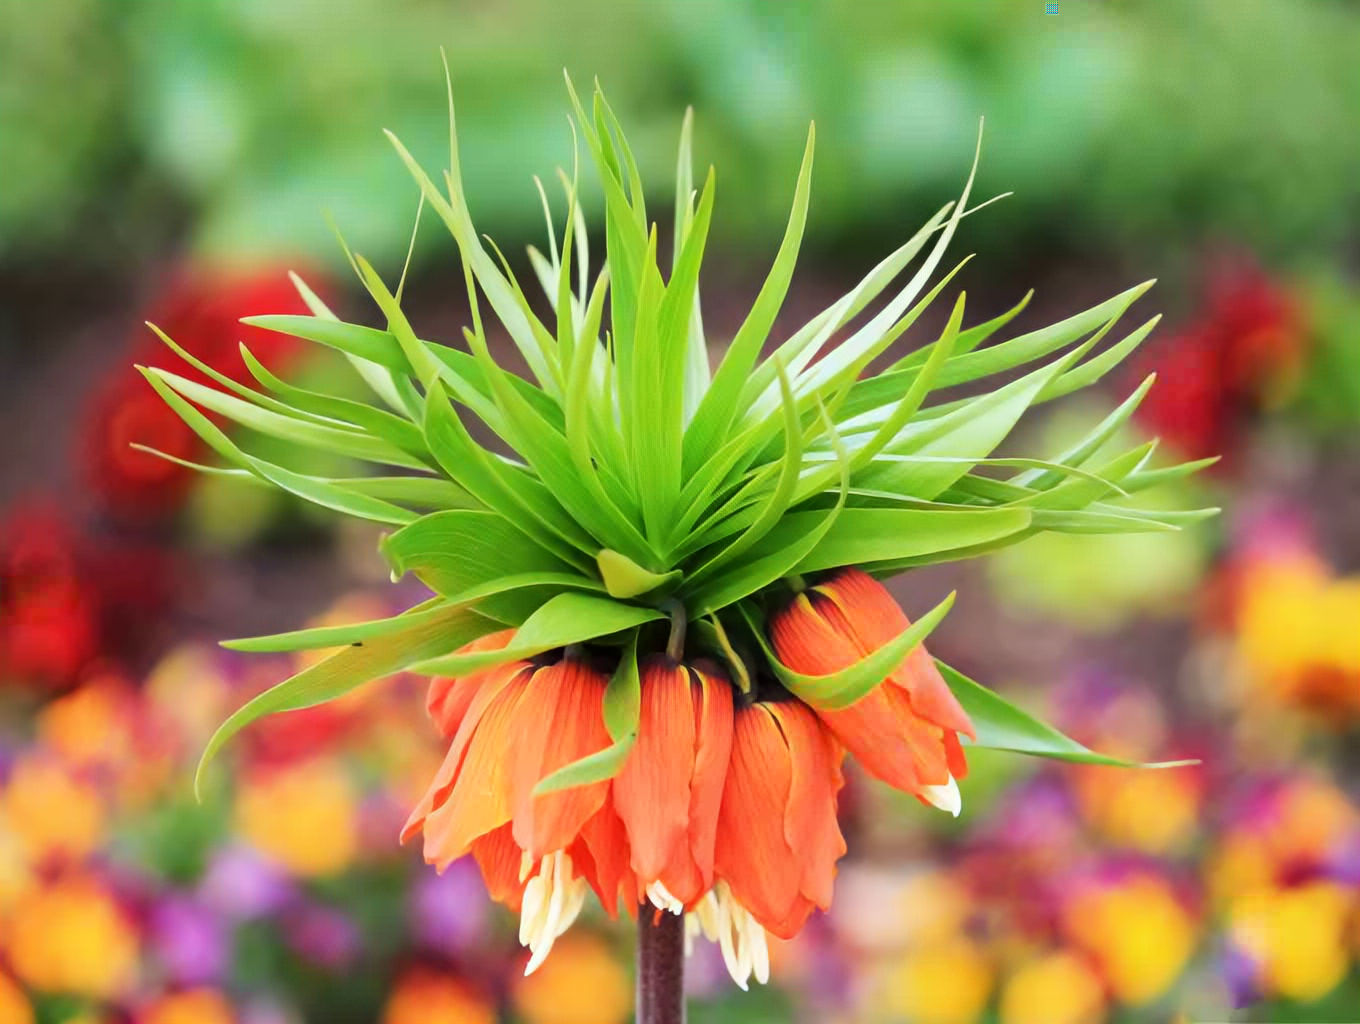

In [ ]:
p